# Wikipedia Notable Life Expectancies
# [Notebook  13: Models](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_models_thanak_2022_10_14.ipynb)
### Context

The
### Objective

The
### Data Dictionary
- Feature: Description

### Importing Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
# import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    BaggingRegressor,
)
from xgboost import XGBRegressor

# To randomly split data, for cross validation, and to check model performance
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for hyperparameter tuning searches
from scipy.stats import loguniform
from scipy.stats import uniform
from scipy.stats import expon

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 211)

# To set some dataframe visualization attributes
pd.set_option("max_colwidth", 150)

# To supress scientific notations for a dataframe
# pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some plot visualization attributes
sns.set_theme()
sns.set(font_scale=1.4)
sns.set_palette(
    (
        "midnightblue",
        "goldenrod",
        "maroon",
        "darkolivegreen",
        "cadetblue",
        "tab:purple",
        "yellowgreen",
    )
)
# plt.rc("font", size=12)
# plt.rc("axes", titlesize=15)
# plt.rc("axes", labelsize=14)
# plt.rc("xtick", labelsize=13)
# plt.rc("ytick", labelsize=13)
# plt.rc("legend", fontsize=13)
# plt.rc("legend", fontsize=14)
# plt.rc("figure", titlesize=16)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### [Reading](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_train_preproc.csv), Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
data = pd.read_csv("wp_life_expect_train_preproc.csv")

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 77624 rows and 20 columns.


,num_references,age,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,age_sqrd,recip_num_references,years,years_sqrd,region,prior_region,known_for
0,4,73.0,0,0,1,0,0,0,0,0,0,0,1,5329.0,0.250000,8,64,Europe,No Prior Region,spiritual
1,3,90.0,1,0,0,1,0,0,0,0,0,0,2,8100.0,0.333333,13,169,North America,No Prior Region,two


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,num_references,age,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,age_sqrd,recip_num_references,years,years_sqrd,region,prior_region,known_for
77622,7,74.0,0,0,0,0,0,1,0,0,0,0,1,5476.0,0.142857,0,0,North America,No Prior Region,arts
77623,5,92.0,0,0,0,0,0,0,1,0,0,0,1,8464.0,0.200000,8,64,Europe,No Prior Region,sports


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,num_references,age,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,num_categories,age_sqrd,recip_num_references,years,years_sqrd,region,prior_region,known_for
8270,8,76.0,0,0,0,0,0,1,0,0,0,0,1,5776.0,0.125000,13,169,Asia,No Prior Region,arts
23652,5,75.0,0,0,0,0,0,0,0,0,1,0,1,5625.0,0.200000,27,729,South America,No Prior Region,politics_govt_law
8533,3,79.0,0,0,0,0,0,0,1,0,0,0,1,6241.0,0.333333,9,81,Europe,No Prior Region,sports
40676,14,43.0,0,0,0,0,0,1,0,0,0,0,1,1849.0,0.071429,8,64,Asia,No Prior Region,arts
58189,4,91.0,0,0,0,0,0,1,0,0,0,0,1,8281.0,0.250000,25,625,North America,No Prior Region,arts


<IPython.core.display.Javascript object>

### Checking Data Types and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77624 entries, 0 to 77623
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_references             77624 non-null  int64  
 1   age                        77624 non-null  float64
 2   sciences                   77624 non-null  int64  
 3   social                     77624 non-null  int64  
 4   spiritual                  77624 non-null  int64  
 5   academia_humanities        77624 non-null  int64  
 6   business_farming           77624 non-null  int64  
 7   arts                       77624 non-null  int64  
 8   sports                     77624 non-null  int64  
 9   law_enf_military_operator  77624 non-null  int64  
 10  politics_govt_law          77624 non-null  int64  
 11  crime                      77624 non-null  int64  
 12  num_categories             77624 non-null  int64  
 13  age_sqrd                   77624 non-null  flo

<IPython.core.display.Javascript object>

#### Observations:
- With our dataset loaded, we are ready for modeling.
- We have three variables that need typcasting from object to category, then one hot encoding just prior to modeling.

#### Typecasting `region`, `prior_region`, and `known_for` as Categorical

In [6]:
# Typcasting prior_region and region as categorical
df[["prior_region", "region", "known_for"]] = df[
    ["prior_region", "region", "known_for"]
].astype("category")

# Re-check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77624 entries, 0 to 77623
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   num_references             77624 non-null  int64   
 1   age                        77624 non-null  float64 
 2   sciences                   77624 non-null  int64   
 3   social                     77624 non-null  int64   
 4   spiritual                  77624 non-null  int64   
 5   academia_humanities        77624 non-null  int64   
 6   business_farming           77624 non-null  int64   
 7   arts                       77624 non-null  int64   
 8   sports                     77624 non-null  int64   
 9   law_enf_military_operator  77624 non-null  int64   
 10  politics_govt_law          77624 non-null  int64   
 11  crime                      77624 non-null  int64   
 12  num_categories             77624 non-null  int64   
 13  age_sqrd                   7762

<IPython.core.display.Javascript object>

## Data Preparation for Modeling
In contrast to building the [linear regression model](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb), we will be tuning these models.  So, we will split the train set into train and validation sets and utilize the `test` set only to check out-of-sample performance of the champion model.  We will load and treat the test set at that point.

### Defining Independent and Dependent Variables for Train and Validation Sets

In [7]:
# Creating list of predictor columns
predictor_cols = [
    "num_references",
    "years",
    "region",
    "prior_region",
    "known_for",
]

# Defining target column
target = "age"

# Defining independent and dependent variables
X = df[predictor_cols]
y = df[target]

# One hot encoding of categorical predictors and typecasting all predictors as float
X = pd.get_dummies(X, drop_first=True).astype("float64")

# Splitting into 70:30 train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Checking shape of train and validation sets
print(
    f"There are {X_train.shape[0]} rows and {X_train.shape[1]} columns in the train set.\n"
)
print(
    f"There are {X_val.shape[0]} rows and {X_val.shape[1]} columns in the validation set.\n"
)

# Checking a sample
X_train.sample()

There are 54336 rows and 34 columns in the train set.

There are 23288 rows and 34 columns in the validation set.



,num_references,years,region_Asia,region_Central Asia,region_Europe,region_Mid-Cent America/Caribbean,region_Middle East,region_North America,region_Oceania,region_Russian Federation,region_South America,region_South East Asia,prior_region_Asia,prior_region_Central Asia,prior_region_Europe,prior_region_Mid-Cent America/Caribbean,prior_region_Middle East,prior_region_No Prior Region,prior_region_North America,prior_region_Oceania,prior_region_Russian Federation,prior_region_South America,prior_region_South East Asia,known_for_arts,known_for_business_farming,known_for_crime,known_for_law_enf_military_operator,known_for_politics_govt_law,known_for_sciences,known_for_social,known_for_spiritual,known_for_sports,known_for_three_to_five,known_for_two
40501,8.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

## Model Building
#### Model Evaluation Criterion
The predictions made by the regressors will have the following performance metrics:
- RMSE
- MAE
- R$^2$
- Ajusted R$^2$
- MAPE

#### Which Metric to Optimize?
- For hyperparameter tuning, we will optimize R$^2$, which is the proportion of variation in the target that is explained by the predictors.  

- To select the champion model, will compare Adjusted R$^2$.  It is the metric that represents the amount of variation in the target that is explained by the predictors, with a penalty for more predictors.  The number of included predictors may vary between algorithms, especially as we are building including examples of decion tree regressors.  R$^2$ will improve with the addition of predictors, even if they contribute very little to the model, whereas, the penalty in Adjusted R$^2$ offsets such an increase.

#### Functions for Checking and Tuning Model Performance

In [8]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs((targets - predictions) / targets)) * 100


# Function to compute and display different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute and return a dataframe of different metrics to check
    regression model performance
    
    model: regressor
    predictors: independent variables
    target: dependent variable
    """
    # Predictions
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)  # To compute MAE
    mape = mape_score(target, pred)  # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

#### Defining Scorer for Cross-validation and Hyperparameter Tuning

In [9]:
# Type of scoring used to compare parameter combinations--maximizing Adj R-squared
scorer = "r2"

<IPython.core.display.Javascript object>

### Building the Models

In [10]:
%%time

# Creating list to store the models
models = []

# Appending models to the list
models.append(('Dtree', DecisionTreeRegressor(random_state=42)))

models.append(('Random Forest', RandomForestRegressor(random_state=42)))

models.append(('Bagging Dtree', BaggingRegressor(random_state=42)))

models.append(('GBM', GradientBoostingRegressor(random_state=42)))

models.append(('AdaBoost Dtree', AdaBoostRegressor(random_state=42)))

models.append(('XGB_gbtree', XGBRegressor(random_state=42)))

models.append(('XGB_gblinear', XGBRegressor(random_state=42, booster='gblinear')))

# Create empty list to store all model's names and CV scores
names = []
results = []

# Loop through all models to get the mean cross validated score
print("\n" "Cross-Validation:" "\n")

for name, model in models:
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=5
    )
    results.append(cv_result)
    names.append(name)
    print(f"{name}: {cv_result.mean()}")
    
print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = r2_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation:

Dtree: -0.3729288388785845
Random Forest: -0.06498999161620542
Bagging Dtree: -0.09780574269930184
GBM: 0.10092407348408765
AdaBoost Dtree: -0.041942386214516916
XGB_gbtree: 0.08816799208071073
XGB_gblinear: 0.0829309055899347

Validation Performance:

Dtree: -0.3725798827812159
Random Forest: -0.06593088660036917
Bagging Dtree: -0.09925861808350978
GBM: 0.10355465508610728
AdaBoost Dtree: -0.05608653156428711
XGB_gbtree: 0.09146574210948322
XGB_gblinear: 0.08706271812469857
CPU times: total: 3min 57s
Wall time: 1min 21s


<IPython.core.display.Javascript object>

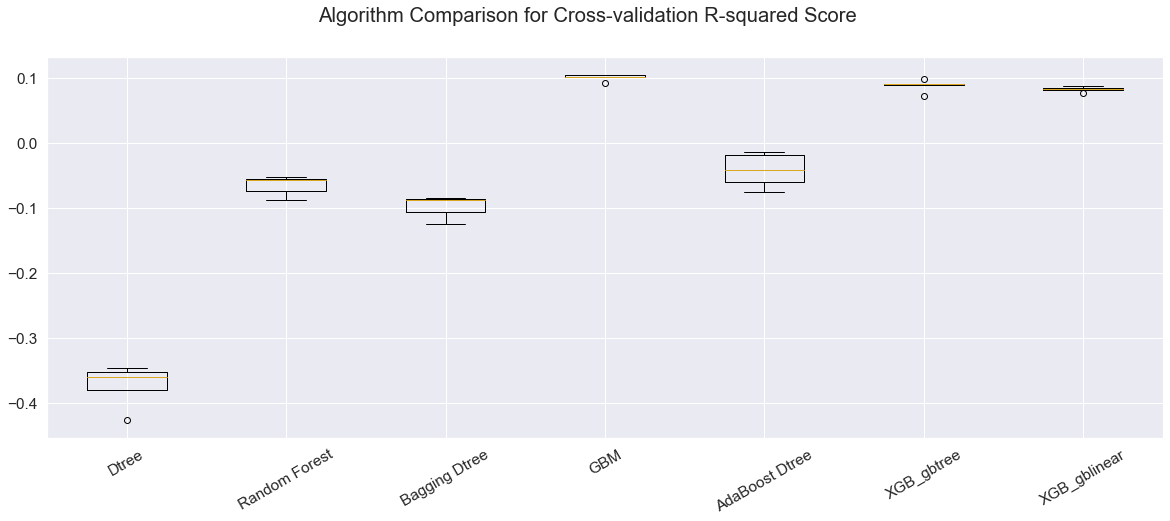

<IPython.core.display.Javascript object>

In [11]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(20, 7))

fig.suptitle("Algorithm Comparison for Cross-validation R-squared Score")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=30)

plt.show()

#### Observations:
- We have negative R$^2$ values for four of the models.  This means they are performing worse than a model that merely equates the predicted values to the constant mean value of the target.
- The remaining three models, *GBM*, *XGB_gbtree*, and *XGB_gblinear* are giving generalized performances on train and validation sets, with similar, albeit very low, R$^2$ scores as [*olsmodel3*](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb) (0.087).  Before hyperparameter tuning, GBM is outperforming the other models, including *olsmodel3*, with both train and validation R$^2$ scores of ~0.10.
- We will perform hyperparameter tuning on the top 3 models.  Purely as an exercise we will also keep Random Forest in the mix.

#### Collecting Models with Best Performance

In [12]:
# List of top models so far
top_models = [models[1]] + [models[3]] + models[-2:]

<IPython.core.display.Javascript object>

#### Creating Dataframes to Compare Training and Validation Performance of Best Models

In [13]:
# Creating empty dictionary to hold the models
models_to_tune = {}

# For loop to add models to dictionary
for model in top_models:
    key = model[0]
    value = model[1]
    models_to_tune[key] = value

# Initializing dataframes to compare performance of all models
models_train_comp_df = pd.DataFrame()
models_val_comp_df = pd.DataFrame()

# For loop to add performance results of each top model
for name, model in models_to_tune.items():
    models_train_comp_df[name] = model_performance_regression(model, X_train, y_train).T
    models_val_comp_df[name] = model_performance_regression(model, X_val, y_val).T

<IPython.core.display.Javascript object>

#### Comparing Top Models Before Hyperparameter Tuning

In [14]:
# Comparing train performance
print(f"Training Performance:")
models_train_comp_df

Training Performance:


,Random Forest,GBM,XGB_gbtree,XGB_gblinear
RMSE,11.686697,14.971421,14.237993,15.177117
MAE,8.736482,11.627512,11.034927,11.785046
R-squared,0.456950,0.108786,0.193965,0.084128
Adj. R-squared,0.456610,0.108228,0.193461,0.083555
MAPE,13.944396,19.221156,18.032207,19.426353


<IPython.core.display.Javascript object>

In [15]:
# Comparing validation performance
print(f"Validation Performance:")
models_val_comp_df

Validation Performance:


,Random Forest,GBM,XGB_gbtree,XGB_gblinear
RMSE,16.271584,14.922006,15.022284,15.058641
MAE,12.558769,11.580272,11.632590,11.697032
R-squared,-0.065931,0.103555,0.091466,0.087063
Adj. R-squared,-0.067489,0.102244,0.090137,0.085728
MAPE,20.193462,19.051063,19.008358,19.182743


<IPython.core.display.Javascript object>

#### Observations:
- Here, we compare the performance on the whole train set to the validation set.
- Only *GBM* and *XGB_gblinear* are giving generalized performances on the two sets.
- These two are performing on par or slightly better than [*olsmodel3*](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_olsmodel_thanak_2022_10_9.ipynb), our linear regression model, for all metrics.
- We will see if hyperparameter tuning improves their performance, again keeping *Rand Forest* and *XGB_tree* in the mix for demonstration and comparison.

## Hyperparameter Tuning

### *Random Forest Tuned*

In [16]:
# Confirming the model
models_to_tune["Random Forest"]

RandomForestRegressor(random_state=42)

<IPython.core.display.Javascript object>

In [17]:
%%time

# Defining model
Model = RandomForestRegressor(random_state=42)

# Parameter grid to pass in RandomizedSearchCV
param_grid = { 
    "n_estimators": np.arange(100, 500), 
    "min_samples_leaf": [None] + np.arange(1, 10).tolist(),
    "max_features": ['sqrt'], 
    "max_samples": uniform(loc=0.3, scale=0.5),
    'criterion': ['squared_error'],
    "max_depth": [None]
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

C:\Users\Teres\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Teres\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Teres\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Teres\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Teres\anaconda3\lib\site-packages\jobl

Best parameters are {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.3909124836035503, 'min_samples_leaf': 4, 'n_estimators': 260} with CV score=0.09967033141183923:
CPU times: total: 3.67 s
Wall time: 1min 5s


<IPython.core.display.Javascript object>

In [18]:
# Building model with best parameters
Random_Forest_tuned = RandomForestRegressor(
    criterion="squared_error",
    max_depth=None,
    max_features="sqrt",
    max_samples=0.3909124836035503,
    min_samples_leaf=4,
    n_estimators=260,
)

# Fit the model on training data
Random_Forest_tuned.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', max_samples=0.3909124836035503,
                      min_samples_leaf=4, n_estimators=260)

<IPython.core.display.Javascript object>

In [19]:
# Calculating different metrics
Random_Forest_tuned_train_perf = model_performance_regression(
    Random_Forest_tuned, X_train, y_train
)
print("Training performance:\n", Random_Forest_tuned_train_perf)
Random_Forest_tuned_val_perf = model_performance_regression(
    Random_Forest_tuned, X_val, y_val
)
print("\nValidation performance:\n", Random_Forest_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["Random Forest Tuned"] = Random_Forest_tuned_train_perf.T
models_val_comp_df["Random Forest Tuned"] = Random_Forest_tuned_val_perf.T

Training performance:
         RMSE       MAE  R-squared  Adj. R-squared       MAPE
0  14.580106  11.32986   0.154765        0.154236  18.735587

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.950537  11.603667   0.100123        0.098808  19.094687


<IPython.core.display.Javascript object>

#### Observations:
- Hyperparameter tuning improved performance for *Random Forest*.
- The algorithm is still overfitting the train set, compared to the validation set.

### *GBM Tuned*

In [20]:
# Confirming the model
models_to_tune["GBM"]

GradientBoostingRegressor(random_state=42)

<IPython.core.display.Javascript object>

In [21]:
%%time

# Defining model
Model = GradientBoostingRegressor(random_state=42)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": np.arange(100, 500),
    "learning_rate": loguniform(0.001, 1),
    "subsample": uniform(loc=0.3, scale=0.5),
    "max_features": uniform(loc=0.3, scale=0.5),
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'learning_rate': 0.08171272700715591, 'max_features': 0.6630456668613307, 'n_estimators': 368, 'subsample': 0.7847684335570795} with CV score=0.1063224214498147:
CPU times: total: 17.8 s
Wall time: 8min 3s


<IPython.core.display.Javascript object>

In [22]:
# Building model with best parameters
GBM_tuned = GradientBoostingRegressor(
    random_state=42,
    learning_rate=0.08171272700715591,
    max_features=0.6630456668613307,
    n_estimators=368,
    subsample=0.7847684335570795,
)

# Fit the model on training data
GBM_tuned.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.08171272700715591,
                          max_features=0.6630456668613307, n_estimators=368,
                          random_state=42, subsample=0.7847684335570795)

<IPython.core.display.Javascript object>

In [23]:
# Calculating different metrics
GBM_tuned_train_perf = model_performance_regression(GBM_tuned, X_train, y_train)
print("Training performance:\n", GBM_tuned_train_perf)
GBM_tuned_val_perf = model_performance_regression(GBM_tuned, X_val, y_val)
print("\nValidation performance:\n", GBM_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["GBM Tuned"] = GBM_tuned_train_perf.T
models_val_comp_df["GBM Tuned"] = GBM_tuned_val_perf.T

Training performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.835035  11.521845   0.124949        0.124401  18.989296

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.877704  11.542386    0.10887        0.107567  18.937928


<IPython.core.display.Javascript object>

#### Observations:
- The performance for *GBM* is improved with hyperparameter tuning.  
- There is a slight increase in overfitting, but the validation metrics are better.

### *XGB_gbtree Tuned*

In [24]:
# Confirming the model
models_to_tune["XGB_gbtree"]

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

In [25]:
%%time

# Defining model
Model = XGBRegressor(random_state=42, booster='gbtree')

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    'n_estimators': np.arange(100, 500),
    "learning_rate": uniform(0.1, 0.3), # aka eta
    'gamma': expon(), # aka min_split_loss
    'subsample': uniform(loc=0.6, scale=0.2), # proportion of train set to randomly sample prior to growing trees
    'max_depth': np.arange(3, 8).tolist(),
    'colsample_bytree': uniform(loc=0.3, scale=0.5)
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'colsample_bytree': 0.42649508399462055, 'gamma': 1.188792356281234, 'learning_rate': 0.12263036412693079, 'max_depth': 3, 'n_estimators': 404, 'subsample': 0.7391497377969234} with CV score=0.10679644601394585:
CPU times: total: 1min 11s
Wall time: 20min 44s


<IPython.core.display.Javascript object>

In [26]:
# Building model with best parameters
XGB_gbtree_tuned = XGBRegressor(
    booster="gbtree",
    random_state=42,
    colsample_bytree=0.42649508399462055,
    gamma=1.188792356281234,
    learning_rate=0.12263036412693079,
    max_depth=3,
    n_estimators=404,
    subsample=0.7391497377969234,
)

# Fit the model on training data
XGB_gbtree_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.42649508399462055, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=1.188792356281234, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.12263036412693079, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=404, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

In [27]:
# Calculating different metrics
XGB_gbtree_tuned_train_perf = model_performance_regression(
    XGB_gbtree_tuned, X_train, y_train
)
print("Training performance:\n", XGB_gbtree_tuned_train_perf)
XGB_gbtree_tuned_val_perf = model_performance_regression(XGB_gbtree_tuned, X_val, y_val)
print("\nValidation performance:\n", XGB_gbtree_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["XGB_gbtree Tuned"] = XGB_gbtree_tuned_train_perf.T
models_val_comp_df["XGB_gbtree Tuned"] = XGB_gbtree_tuned_val_perf.T

Training performance:
         RMSE       MAE  R-squared  Adj. R-squared       MAPE
0  14.813429  11.50438   0.127496         0.12695  18.953973

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.882834  11.546377   0.108255        0.106951  18.931955


<IPython.core.display.Javascript object>

#### Observations:
- The performance for *XGB_gbtree* is improved with hyperparameter tuning.  
- There is a slight increase in overfitting, but the validation metrics are better.

### *XGB_gblinear Tuned*

In [28]:
# Confirming the model
models_to_tune["XGB_gblinear"]

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=0, reg_lambda=0, ...)

<IPython.core.display.Javascript object>

In [29]:
%%time

# Defining model
Model = XGBRegressor(random_state=42, booster='gblinear')

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    'n_estimators': np.arange(100, 500),
    'reg_lambda': loguniform(.0001, 1)
}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=42,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

# Chime notification when cell successfully executes
chime.success()

Best parameters are {'n_estimators': 439, 'reg_lambda': 0.0009206654892274761} with CV score=0.09196572057161607:
CPU times: total: 43.5 s
Wall time: 5min 45s


<IPython.core.display.Javascript object>

In [30]:
# Building model with best parameters
XGB_gblinear_tuned = XGBRegressor(
    booster="gblinear",
    random_state=42,
    n_estimators=439,
    reg_lambda=0.0009206654892274761,
)

# Fit the model on training data
XGB_gblinear_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None, gpu_id=-1,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=439, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=0, reg_lambda=0.0009206654892274761, ...)

<IPython.core.display.Javascript object>

In [31]:
# Calculating different metrics
XGB_gblinear_tuned_train_perf = model_performance_regression(
    XGB_gblinear_tuned, X_train, y_train
)
print("Training performance:\n", XGB_gblinear_tuned_train_perf)
XGB_gblinear_tuned_val_perf = model_performance_regression(
    XGB_gblinear_tuned, X_val, y_val
)
print("\nValidation performance:\n", XGB_gblinear_tuned_val_perf)

# Adding model to model comparison dataframes
models_train_comp_df["XGB_gblinear Tuned"] = XGB_gblinear_tuned_train_perf.T
models_val_comp_df["XGB_gblinear Tuned"] = XGB_gblinear_tuned_val_perf.T

Training performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  15.103211  11.729315   0.093026        0.092458  19.393305

Validation performance:
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  14.995187  11.640146    0.09474        0.093417  19.151862


<IPython.core.display.Javascript object>

## Model Performance Comparison and Choosing the Final Model

### Performance of Various Models Tuned and Untuned

In [32]:
# Displaying train performance of all models
print("Train Performance Comparison:")
models_train_comp_df.sort_index(axis=1)

Train Performance Comparison:


,GBM,GBM Tuned,Random Forest,Random Forest Tuned,XGB_gblinear,XGB_gblinear Tuned,XGB_gbtree,XGB_gbtree Tuned
RMSE,14.971421,14.835035,11.686697,14.580106,15.177117,15.103211,14.237993,14.813429
MAE,11.627512,11.521845,8.736482,11.329860,11.785046,11.729315,11.034927,11.504380
R-squared,0.108786,0.124949,0.456950,0.154765,0.084128,0.093026,0.193965,0.127496
Adj. R-squared,0.108228,0.124401,0.456610,0.154236,0.083555,0.092458,0.193461,0.126950
MAPE,19.221156,18.989296,13.944396,18.735587,19.426353,19.393305,18.032207,18.953973


<IPython.core.display.Javascript object>

In [33]:
# Displaying validation performance of all models
print("Validation Performance Comparison:")
models_val_comp_df.sort_index(axis=1)

Validation Performance Comparison:


,GBM,GBM Tuned,Random Forest,Random Forest Tuned,XGB_gblinear,XGB_gblinear Tuned,XGB_gbtree,XGB_gbtree Tuned
RMSE,14.922006,14.877704,16.271584,14.950537,15.058641,14.995187,15.022284,14.882834
MAE,11.580272,11.542386,12.558769,11.603667,11.697032,11.640146,11.632590,11.546377
R-squared,0.103555,0.108870,-0.065931,0.100123,0.087063,0.094740,0.091466,0.108255
Adj. R-squared,0.102244,0.107567,-0.067489,0.098808,0.085728,0.093417,0.090137,0.106951
MAPE,19.051063,18.937928,20.193462,19.094687,19.182743,19.151862,19.008358,18.931955


<IPython.core.display.Javascript object>

#### Observations:
- *GBM Tuned* has the highest R$^2$ (0.109) on the validation set, followed by *XGB_gbtree Tuned*, then *GBM*.
- As we did not include the Decision Tree here, we can ignore Adjusted R$^2$, and just compare R$^2$.
- Of these three models with R$^2$ scores over 10, there is some variation in overfitting.

#### Comparison of Percentage of Overfitting for R$^2$

In [34]:
# Subtracting the ratio of validation R-square/train R-square from 1
overfit_perc = (
    1
    - (
        models_val_comp_df.loc["R-squared", :]
        / models_train_comp_df.loc["R-squared", :]
    )
) * 100

print(f"Percentage of R-square overfitting:")
overfit_perc.sort_values()

Percentage of R-square overfitting:


XGB_gblinear            -3.488252
XGB_gblinear Tuned      -1.842618
GBM                      4.808487
GBM Tuned               12.868707
XGB_gbtree Tuned        15.091493
Random Forest Tuned     35.306120
XGB_gbtree              52.844295
Random Forest          114.428464
Name: R-squared, dtype: float64

<IPython.core.display.Javascript object>

#### Observations:
- *XGB_gblinear* and *XGB_gblinear Tuned* both performed better on the validation set, than the training set, which is interesting.
- Of the top 3 models for R$^2$, *GBM* generalized considerably better than *GBM Tuned* and *XGB_gtree Tuned*.  
- *GBM Tuned* and *XGB_gbtree Tuned* do not give as generalized a performance as it would appear at first glance, comparing train and validation R$^2$ scores directly.
- With such a narrow window for eking out performance, we will choose the more generalized *GBM* as the champion model, and the higher-scoring *GBM Tuned* as the challenger.

## Test Set Performance on Champion Model *GBM*

#### Loading [Pre-processed Test Set](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_test_preproc.csv) 

In [38]:
# Reading test.csv
test = pd.read_csv("wp_life_expect_test_preproc.csv")

# Checking shape
print(f"There are {test.shape[0]} rows and {test.shape[1]} columns in the test set.")

There are 19420 rows and 20 columns in the test set.


<IPython.core.display.Javascript object>

#### Checking Data Types and Null Values

In [39]:
# Checking data types and null values
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19420 entries, 0 to 19419
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_references             19420 non-null  int64  
 1   age                        19420 non-null  float64
 2   sciences                   19420 non-null  int64  
 3   social                     19420 non-null  int64  
 4   spiritual                  19420 non-null  int64  
 5   academia_humanities        19420 non-null  int64  
 6   business_farming           19420 non-null  int64  
 7   arts                       19420 non-null  int64  
 8   sports                     19420 non-null  int64  
 9   law_enf_military_operator  19420 non-null  int64  
 10  politics_govt_law          19420 non-null  int64  
 11  crime                      19420 non-null  int64  
 12  num_categories             19420 non-null  int64  
 13  age_sqrd                   19420 non-null  flo

<IPython.core.display.Javascript object>

In [37]:
print("Complete")

# Chime notification when cell executes
chime.success()

Complete


<IPython.core.display.Javascript object>

# [Proceed to Data Cleaning Part ]()